# ENSO_duration: Duration of SST Anomalies in the Central Equatorial Pacific  

Computes the number of months during which sea surface temperature anomalies (SSTA) persist in the Niño3.4 region (horizontal average over 5°S–5°N, 170°W–120°W). This metric evaluates the duration of SST anomalies during the 6 years centred on the peak of ENSO events, comparing model simulations with reference observations.

## Datasets Used for Duration Comparison  

The following reference datasets are used to evaluate the duration of ENSO-related SST anomalies in model simulations:  

- **TropFlux (1979–2018)**: The primary dataset for comparison, designed for analysing tropical climate variability, including surface fluxes and SST anomalies.  

Additional datasets include:  
- **20CRv2 (1871–2012)**: A historical reanalysis product providing long-term atmospheric data using surface pressure observations.  
- **ERA-Interim (1979–2018)**: A high-resolution reanalysis dataset offering consistent atmospheric and surface variable estimates.  
- **ERSSTv5 (1854–2018)**: A globally gridded dataset optimised for climate monitoring, including ENSO-related SST anomaly studies.  
- **HadISST (1870–2018)**: A historical dataset combining SST and sea ice observations with reconstructions.  
- **NCEP2 (1979–2018)**: A second-generation reanalysis product delivering improved atmospheric and surface data globally.  

## Dask Cluster 

Start a cluster with multiple cores 

In [ ]:
from dask.distributed import Client, progress
client = Client()
client

## Datasets

In [1]:
from esmvalcore.dataset import Dataset

In [9]:
model_datasets = {
"ACCESS-CM2": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19000101/20190101",
    dataset="ACCESS-CM2",
    grid="gn"
)}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
}

In [10]:
# add ancillary
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftof', mip="Ofx")
    dataset.add_supplementary(short_name="areacello", mip="Ofx")

In [11]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [12]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np


In [13]:
def sst_enso_n34(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube, period='monthly')
    cube = detrend(cube, dimension="time", method="linear")
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)##rolling window cuts off months?
    # cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube,operator='mean')

    return cube


In [14]:
model_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully d

## Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the difference between the model and the reference.

In [15]:
# 
def sst_regressed(n34):
    n34_dec = extract_month(n34, 12)
    leadlagyr = 3 #rolling window cut off, not include first year
    n34_dec_years = [n34_dec.coord('time').units.num2date(time).year 
                     for time in n34_dec.coord('time').points]
    event_years = n34_dec_years[leadlagyr:-leadlagyr]
    # Ensure that the selected years are not the last years
    event_constr = iris.Constraint(time=lambda cell: cell.point.year in event_years)
    n34_dec_ct = n34_dec.extract(event_constr)

    years_of_interest=[]
    for yr in event_years:
        years_of_interest.append([yr - 2, yr - 1, yr, yr + 1, yr + 2, yr + 3])
        
    n34_selected = []
    for enso_epoch in years_of_interest:
        # Select the data for the current year and append it to n34_selected
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in enso_epoch)
        cube_2 = n34.extract(year_enso)
        n34_selected.append(cube_2.data.data)

    # 1) linear regression of sst_time_series on sst_enso
    A_data = np.array(n34_selected)
    B_data = n34_dec_ct.data
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)

    return coefs[0]

In [16]:
model = sst_regressed(model_datasets_prep1["ACCESS-CM2"])
obs = sst_regressed(obs_datasets_prep1["HadISST"])

In [17]:
## duration

# Plot the slope and correlation
# Define the lead/lag months
months = np.arange(1, 73) - 36

obs_model_count = []
# Calculate the number of months where slope > 0.25 in the range -20 to 20
within_range = (months >= -30) & (months <= 30)
slope_above_025 = model[within_range] > 0.25
obs_model_count.append(np.sum(slope_above_025))

slope_above_025 = obs[within_range] > 0.25
obs_model_count.append(np.sum(slope_above_025))

metric = abs((obs_model_count[1]-obs_model_count[0])/obs_model_count[0])*100
metric, obs_model_count

(8.333333333333332, [12, 13])

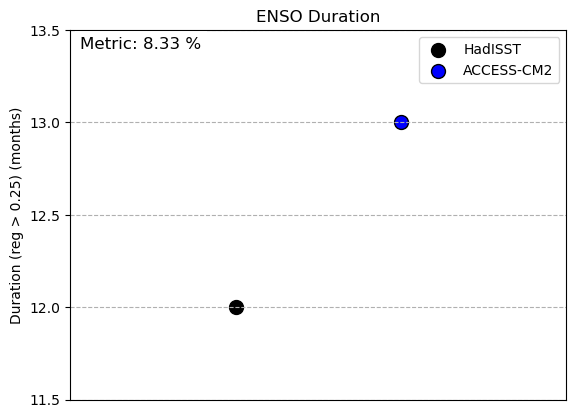

In [22]:
# Set x_position to represent the model (1, 2, or 3)
x_position = [1, 2]  # Change this to 1, 2, or 3 based on your requirement
label_array = ['HadISST', 'ACCESS-CM2']

# Plot the HadISST duration point in black
plt.scatter(x_position[0], obs_model_count[0], color='black', edgecolor='black', s=100, marker='o', label=label_array[0])

# Plot the Model 2 duration point in blue
plt.scatter(x_position[1], obs_model_count[1], color='blue', edgecolor='black', s=100, marker='o', label=label_array[1])

plt.text(0.02, 0.95, f'Metric: {metric:.2f} %', fontsize=12, ha='left', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.xlim(0,3)
plt.xticks([])

# Add labels and title
# plt.xlabel('Model')
plt.ylabel('Duration (reg > 0.25) (months)')
plt.title('ENSO Duration')
plt.yticks(np.arange(min(obs_model_count)-0.5, max(obs_model_count)+1, 0.5))
# Optionally add a grid and legend
plt.grid(linestyle='--')

plt.legend()

# Show the plot
plt.show()


**Figure 1**: Duration of the ENSO life cycle where SSTA exceeds 0.25, illustrating the "duration" of the SSTA event. The model typically shows a duration close to the reference, but slightly longer. The black markers represent the reference data, while the blue markers represent the model output. The derived metric is the absolute relative difference, calculated as: \( \text{abs}((\text{model} - \text{ref}) / \text{ref}) \times 100 \).


## Diagnostic Level 2

The second level shows the temporal evolution of SSTA during ENSO: the ENSO life-cycle.

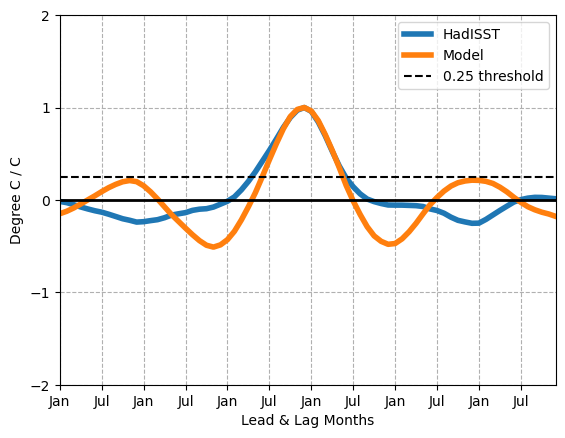

In [23]:
# Plot the slope
plt.plot(months, obs, label='HadISST', lw=4)
plt.plot(months, model, label='Model', lw=4)

# Draw a black dashed line at y=0.25
plt.axhline(y=0.25, color='black', linestyle='--', label='0.25 threshold')

# Draw a thicker line at y=0
plt.axhline(y=0, color='black', linewidth=2) #, label='Zero Line')

# Define custom ticks for the x-axis (every 6 months)
xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)
plt.xlim(-35,36)
# Set the labels and titles
plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C / C')
plt.legend()
plt.grid(linestyle='--')

# Apply the custom ticks and labels to the x-axis
plt.xticks(xticks, xtick_labels)
plt.yticks(np.arange(-2,2.5, step=1))

# Show the plot
plt.show()

**Figure 2**: Temporal structure of sea surface temperature anomalies (SSTA) in the central equatorial Pacific (Niño 3.4 region average), illustrating the temporal evolution of SSTA. The model typically exhibits an overly frequent oscillation between negative and positive SSTA phases. The black curve represents the reference data, while the blue curve corresponds to the model output.


## Diagnostic level 3
The third level is similar to the first, but with La Niña and El Niño events.

In [24]:
# la nina el nino 
from esmvalcore.preprocessor import (
                        mask_above_threshold, mask_below_threshold,
)
import numpy as np

def mask_to_years(events):
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]
    
def enso_events(cube): # get cube years min/max, remove 3:-3
    datayears = [cube.coord('time').units.num2date(time).year for time in cube.coord('time').points]
    leadlagyrs = datayears[:3] + datayears[-3:]
    std = cube.data.std()
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.75 * std))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.75 * std))
    events = {'la nina':a_events, 'el nino':o_events}
    for key, yrls in events.items():
        events[key] = [yr for yr in yrls if yr not in leadlagyrs]
        
    return events

In [25]:

def enso_composite(n34):
    n34_dec = extract_month(n34, 12)
    events = enso_events(n34_dec) #check years not in first/last 3
    # print(events)
    enso_res = {}
    for enso, years in events.items(): 
        year_contraint = iris.Constraint(time=lambda cell: cell.point.year in years)
        # model_cb = model_n34_dec.extract(year_contraint) #values for regression
        
        years_of_interest=[]
        for yr in years:
            years_of_interest.append([yr - 2, yr - 1, yr, yr + 1, yr + 2, yr + 3])
        
        cube_data={}
        for enso_epoch in years_of_interest:
            year_enso = iris.Constraint(time=lambda cell: cell.point.year in enso_epoch)
            cube_2 = n34.extract(year_enso) #extract rolling 6
            yr = enso_epoch[2]
            cube_data[yr] = cube_2.data.data

        durations = [threshold_duration(line, 0.5, enso) for yr, line in cube_data.items()]
        enso_res[enso] = durations #ls of durations for each event
        
    return enso_res

## count duration for each dataset and enso composite
def threshold_duration(line, value, enso): #below la nina
    if enso == 'el nino':
        cnt_month = line > value
    elif enso == 'la nina':
        cnt_month = line < - value
    cnt = 0
    durations = []
    for a in cnt_month:
        if a:
            cnt += 1
        else:
            if cnt != 0:
                durations.append(cnt)
            cnt = 0
    return max(durations)

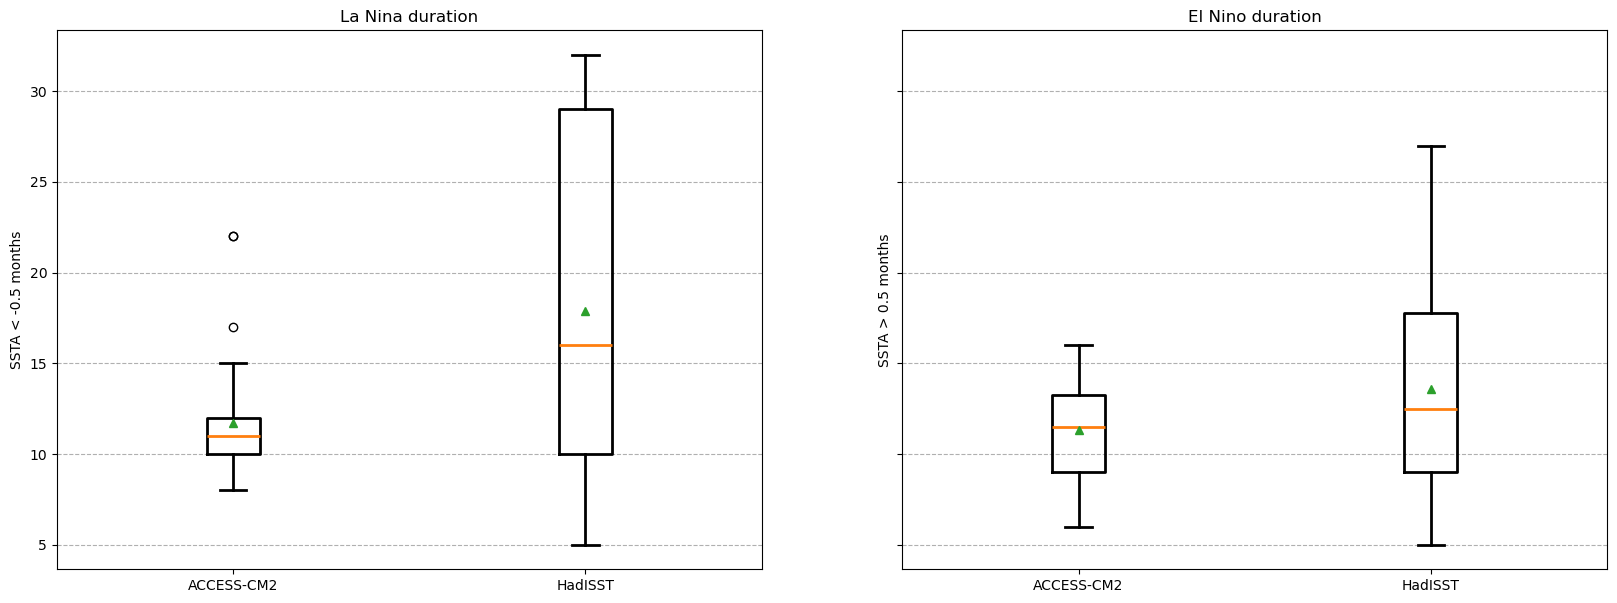

In [26]:
res = enso_composite(model_datasets_prep1["ACCESS-CM2"])
res_obs = enso_composite(obs_datasets_prep1["HadISST"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

nina = [res['la nina'],res_obs['la nina']] # subplots for nina and nino
nino = [res['el nino'],res_obs['el nino']]

bplt = ax1.boxplot(nina, labels=['ACCESS-CM2', 'HadISST'], showmeans=True)
for k in bplt.keys():
    plt.setp(bplt[k], linewidth=2)
    
ax1.set_title('La Nina duration')
ax1.set_ylabel('SSTA < -0.5 months')
ax1.grid(linestyle='--', axis='y')

bplt = ax2.boxplot(nino, labels=['ACCESS-CM2', 'HadISST'], showmeans=True) # whis=(10,90),
for k in bplt.keys():
    plt.setp(bplt[k], linewidth=2)
ax2.set_title('El Nino duration')
ax2.set_ylabel('SSTA > 0.5 months')
ax2.grid(linestyle='--', axis='y')

**Figure 3**: distributions of durations of ENSO events, showing usually too long and too symmetrical durations (some La Niña events should last 2 years, but it is not the case for El Niño). Here the duration of La Niña is too small and 2-years La Niña are unlikely, while 2-years El Niño are simulated. In addition, simulated distributions are too narrow, showing that the model does not simulate the observed diversity of events duration. The black and blue boxplots show respectively the reference and the model, the left and right panels show respectively La Niña distributions and the El Niño distributions. Boxplots: whiskers extend to the 10th and 90th percentiles; boxes encompass the 25th and 75th percentiles; and a diamond marks the mean. La Niña (El Niño) events are defined when December Niño3.4 SSTA (December value smoothed with a 5-month triangular-weighted moving average) is below -0.75 (above 0.75) standard deviation.